In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from regularizers.regularizer import L1Regularizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
# -> /utils/data_utils.py

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


horse horse   dog  frog


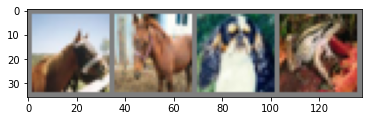

In [4]:
# -> utils/evaluation_utils.py

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
# -> /models/model.py

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
from models.model import Net
net = Net()

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
# ISOLATE TRAINING LOOP

loss_across_epochs = []
latency_across_epochs = []

def training_loop(optimizer,inputs,labels,model,regularizer_loss=None) -> "loss":
    # get the inputs
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # REGULARIZATION
    if regularizer_loss:
        loss = regularizer_loss.regularized_all_param(reg_loss_function=loss)

    loss.backward()
    optimizer.step()

    return loss

In [ ]:
from utils.training_utils import training_loop



In [ ]:
num_of_regularizers = 2

list_of_models = [Net()]*num_of_regularizers

list_of_regularizers = [None,L1Regularizer(model=list_of_models[1], lambda_reg=10**-2)]

In [ ]:
from thop import profile

def calculate_FLOPS(model, input):

    flops, params  = profile(model,  inputs=input)

    return flops

In [ ]:
# TEST FLOPS FUNCTIONALITY

# 1 training cycle for ALL regularizers
# 1 epoch, 1 data point
# for every epoch:
# for every data point:

data1 = next(dataiter)
# net.to(device)

inputs, labels = data1
# inputs, labels = inputs.to(device), labels.to(device) # GPU

#print(inputs.shape) # shape of input 4 3 32 32 

import torchvision.models as models


model1 = list_of_models[0]

model1.eval()

input_tensor = torch.randn(1, 3, 32, 32)
flops, params  = profile(model1,  inputs=(input_tensor,) )

print("Flops" , flops)

In [ ]:
def calculate_loss_latency_for_all_regularizers(inputs,labels):

    loss_across_regularizers = []
    latency_across_regularizers = []

    for regularizer_index,regularizer in enumerate(list_of_regularizers):
        #time each training loop to get latency
        start = time.time()
        loss = training_loop(inputs,labels,regularizer)
        end = time.time()

        loss_across_regularizers.append(loss.item())
        latency_across_regularizers.append(end - start)

    loss_across_epochs.append(loss_across_regularizers)
    latency_across_epochs.append(latency_across_regularizers)
    # print(loss_across_regularizers)

In [ ]:
# -> utils/training_utils.py
# net.to(device)


# TRAINING CHANNEL


for epoch in range(1):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader, 0):
        # limit training time for debugging purposes
        if i > 5:
            break

        data1 = next(dataiter)
        # net.to(device)

        inputs, labels = data1

        #since we are not interested in inference, loss and latency can be calculated in one training loop
        calculate_loss_latency_for_all_regularizers(inputs,labels)
        # calculate_FLOPS()
        print(i)

print('Finished Training')

Resources:

- [cifar10 (Colab)](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=ubQdOyR6FjUB)

- [Iterative Pruning (Colab)](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html)

- [Pruning Experiments (Github)](https://github.com/olegpolivin/pruningExperiments/tree/main)
- [Pruning Experiments (Medium)](https://olegpolivin.medium.com/experiments-in-neural-network-pruning-in-pytorch-c18d5b771d6d)
- [Sparsifying Regularizer (Github)](https://github.com/dizam92/pyTorchReg)

Components
- data loading + preprocessing (/utils/data_utils.py ??)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# -> utils/evaluation_utils.py

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [39]:
from models.model import Net
net = Net()

In [41]:
# ISOLATE TRAINING LOOP

loss_across_epochs = []
latency_across_epochs = []

def training_loop(optimizer,inputs,labels,model,regularizer_loss=None) -> "loss":
    # get the inputs
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # REGULARIZATION
    if regularizer_loss:
        loss = regularizer_loss.regularized_all_param(reg_loss_function=loss)

    loss.backward()
    optimizer.step()

    return loss

In [71]:
num_of_regularizers = 2

list_of_models = [Net()]*num_of_regularizers

list_of_regularizers = [None,L1Regularizer(model=list_of_models[1], lambda_reg=10**-2)]

In [69]:
# TEST FLOPS FUNCTIONALITY

# 1 training cycle for ALL regularizers
# 1 epoch, 1 data point
# for every epoch:
# for every data point:

data1 = next(dataiter)
# net.to(device)

inputs, labels = data1
# inputs, labels = inputs.to(device), labels.to(device) # GPU

#print(inputs.shape) # shape of input 4 3 32 32 

import torchvision.models as models


model1 = list_of_models[0]

model1.eval()

input_tensor = torch.randn(1, 3, 32, 32)
flops, params  = profile(model1,  inputs=(input_tensor,) )

print("Flops" , flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


NameError: name 'F' is not defined

In [ ]:
# -> utils/training_utils.py
# net.to(device)


# TRAINING CHANNEL


for epoch in range(1):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader, 0):
        # limit training time for debugging purposes
        if i > 5:
            break

        data1 = next(dataiter)
        # net.to(device)

        inputs, labels = data1

        #since we are not interested in inference, loss and latency can be calculated in one training loop
        calculate_loss_latency_for_all_regularizers(inputs,labels)
        # calculate_FLOPS()
        print(i)

print('Finished Training')

In [ ]:
######### PLOTTING FIGURES ########

# -> utils/plotting_utils.py
columns=["No Regularizer","L1 Regularizer"]
df = pd.DataFrame(loss_across_epochs, columns=columns)
print(df)
plot = df.plot(title="Regularizer vs Loss")
plot.set(xlabel="Time/Iteration", ylabel="Loss")